# Breast Cancer Detection Model Ver01

## 0. Import Module

- [OpenSlide](https://openslide.org/api/python/#module-openslide)

In [1]:
%matplotlib inline
import os
import csv
import cv2
import openslide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from openslide.deepzoom import DeepZoomGenerator

## 1. Data Load

In [2]:
# slide path
slide_path = '../data/train/16-S-042893_A1.mrxs'  # pos
# neg_slide_path = '../data/train/16-S-042725_A.mrxs'  # neg

# mask path
mask_path = '../data/train/Mask_16-S-042893_A1.png'  # pos
# neg_mask_path = '../data/train/Mask_16-S-042725_A.png'  # neg

# openslide
## slide
slide = openslide.open_slide(slide_path)
# neg_slide = openslide.open_slide(neg_slide_path)
## mask
mask = openslide.open_slide(mask_path)
# neg_mask = openslide.open_slide(neg_mask_path)

In [3]:
print('origin pos_slide.dimensions :', slide.dimensions)
# print('origin neg_slide.dimensions :', neg_slide.dimensions)
print('origin pos_mask.dimensions :', mask.dimensions)
# print('origin neg_mask.dimensions :', neg_mask.dimensions)

origin pos_slide.dimensions : (93970, 234042)
origin pos_mask.dimensions : (5316, 10007)


In [4]:
print("pos_slide's num of levels :", slide.level_count)
print("pos_slide's shape of levels :")
for level, dim in enumerate(slide.level_dimensions):
    print("level {} : {}".format(level, dim))

pos_slide's num of levels : 10
pos_slide's shape of levels :
level 0 : (93970, 234042)
level 1 : (46985, 117021)
level 2 : (23492, 58510)
level 3 : (11746, 29255)
level 4 : (5873, 14627)
level 5 : (2936, 7313)
level 6 : (1468, 3656)
level 7 : (734, 1828)
level 8 : (367, 914)
level 9 : (183, 457)


## 2. Fit Data Shape

### 1) Using min x,y offset

In [5]:
# Path size
PATCH_SIZE = 256

# min x,y offset
min_x, min_y = (7744, 39056)
location = (int(min_x), int(min_y))

# size x, y
size = (int(mask.dimensions[0]/16), int(mask.dimensions[1]/16))

# level
level = int(np.log2(PATCH_SIZE))

# read region
slide_lv4 = slide.read_region(location, level, size)

# thumbnail mask
thumbnail_mask = mask.get_thumbnail(size)  # (332, 625)

In [6]:
print('slide_lv4.size :', slide_lv4.size)
print('thumbnail_mask.size :', thumbnail_mask.size)

slide_lv4.size : (332, 625)
thumbnail_mask.size : (332, 624)


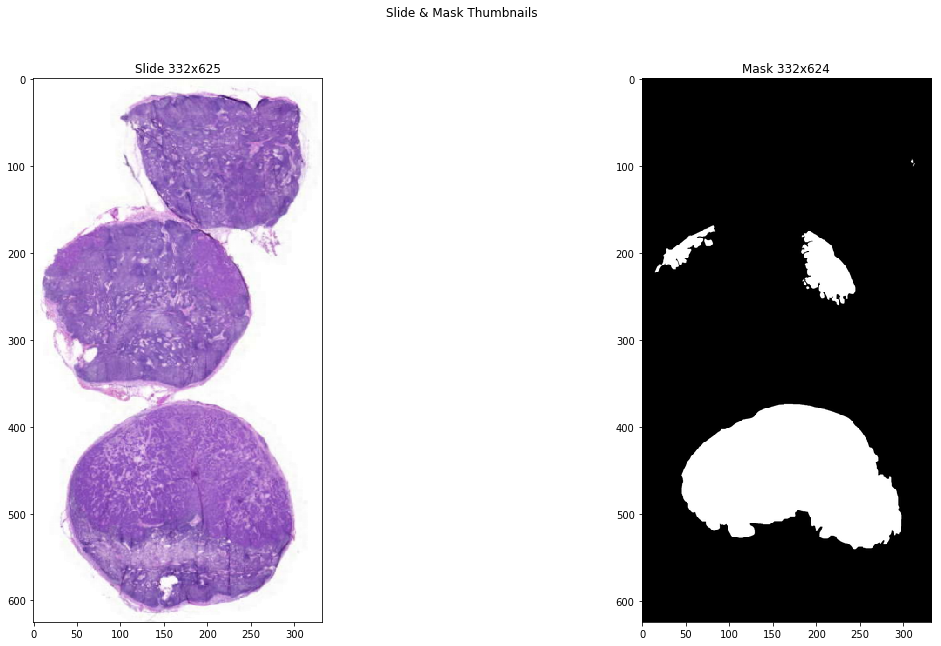

In [7]:
## Plotting
f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide_lv4);
ax[0].set_title('Slide %dx%d' % slide_lv4.size)
ax[1].imshow(thumbnail_mask.convert('L'), cmap='gray');
ax[1].set_title('Mask %dx%d' % thumbnail_mask.size)
f.suptitle('Slide & Mask Thumbnails ');

### 2) Without using min x,y offset

In [8]:
min_x = slide.properties.get(
    openslide.PROPERTY_NAME_BOUNDS_X)

In [9]:
min_y = slide.properties.get(
    openslide.PROPERTY_NAME_BOUNDS_Y)

In [10]:
# Path size
PATCH_SIZE = 256

# min x,y offset
# min_x, min_y = (7744, 39056)
location = (int(min_x), int(min_y))

# size x, y
size = (int(mask.dimensions[0]/16), int(mask.dimensions[1]/16))

# level
level = int(np.log2(PATCH_SIZE))

# read region
slide_lv4 = slide.read_region(location, level, size)

# thumbnail mask
thumbnail_mask = mask.get_thumbnail(size)  # (332, 625)

In [11]:
print('slide_lv4.size :', slide_lv4.size)
print('thumbnail_mask.size :', thumbnail_mask.size)

slide_lv4.size : (332, 625)
thumbnail_mask.size : (332, 624)


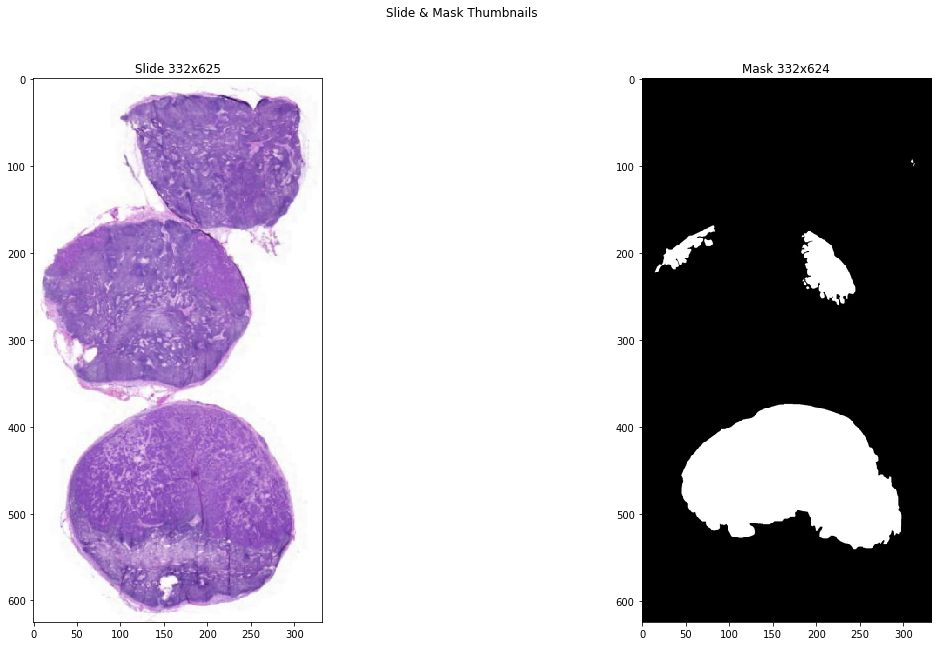

In [12]:
## Plotting
f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide_lv4);
ax[0].set_title('Slide %dx%d' % slide_lv4.size)
ax[1].imshow(thumbnail_mask.convert('L'), cmap='gray');
ax[1].set_title('Mask %dx%d' % thumbnail_mask.size)
f.suptitle('Slide & Mask Thumbnails ');

## 3. Patch Gen

### 1) Patch DataFrame

In [13]:
## set params
PATCH_SIZE = 256
IS_TRAIN = True

# Mask는 원본의 1/16
mask_div = int(PATCH_SIZE / 16)
slide_lv4_grey = np.array(slide_lv4.convert('L'))
ret, th = cv2.threshold(slide_lv4_grey, 0, 255, 
                        cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [23]:
patch_df = pd.DataFrame(pd.DataFrame(th>0).stack(), columns=['is_tissue'])
patch_df['slide_path'] = slide_path
patch_df.head()

is_tissue                         slide_path
0 0      False  ../data/train/16-S-042893_A1.mrxs
  1      False  ../data/train/16-S-042893_A1.mrxs
  2      False  ../data/train/16-S-042893_A1.mrxs
  3      False  ../data/train/16-S-042893_A1.mrxs
  4      False  ../data/train/16-S-042893_A1.mrxs

In [24]:
thumb_size = (mask.dimensions[0]/mask_div, mask.dimensions[1]/mask_div)
mask_thumbnail = mask.get_thumbnail(thumb_size)
mask_thumbnail = np.array(mask_thumbnail.convert('L')).reshape(-1)
mask_thumbnail = mask_thumbnail > 0

# add column patch_df as is_tumor
patch_df['is_tumor'] = mask_thumbnail
patch_df.head()

is_tissue                         slide_path  is_tumor
0 0      False  ../data/train/16-S-042893_A1.mrxs     False
  1      False  ../data/train/16-S-042893_A1.mrxs     False
  2      False  ../data/train/16-S-042893_A1.mrxs     False
  3      False  ../data/train/16-S-042893_A1.mrxs     False
  4      False  ../data/train/16-S-042893_A1.mrxs     False

In [26]:
## Get only tissue
patch_df = patch_df[patch_df['is_tissue'] == True]
print('len of patch_df :', len(patch_df))

len of patch_df : 151178


In [27]:
patch_df.head()

is_tissue                         slide_path  is_tumor
0 141       True  ../data/train/16-S-042893_A1.mrxs     False
  142       True  ../data/train/16-S-042893_A1.mrxs     False
  143       True  ../data/train/16-S-042893_A1.mrxs     False
  144       True  ../data/train/16-S-042893_A1.mrxs     False
  145       True  ../data/train/16-S-042893_A1.mrxs     False

In [29]:
## add tile_loc column
patch_df['tile_loc'] = list(patch_df.index)
patch_df.reset_index(drop=True, inplace=True)
patch_df.head()

/home/cjh/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,is_tissue,slide_path,is_tumor,tile_loc
0,True,../data/train/16-S-042893_A1.mrxs,False,"(0, 141)"
1,True,../data/train/16-S-042893_A1.mrxs,False,"(0, 142)"
2,True,../data/train/16-S-042893_A1.mrxs,False,"(0, 143)"
3,True,../data/train/16-S-042893_A1.mrxs,False,"(0, 144)"
4,True,../data/train/16-S-042893_A1.mrxs,False,"(0, 145)"


### 2) Create Tiles using DeepZoomGenerator

In [31]:
from openslide.deepzoom import DeepZoomGenerator

In [111]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_mask = DeepZoomGenerator(mask, tile_size=16, overlap=0, limit_bounds=False)

In [112]:
patch_x = int(slide.properties.get(openslide.PROPERTY_NAME_BOUNDS_X)) / PATCH_SIZE
patch_y = int(slide.properties.get(openslide.PROPERTY_NAME_BOUNDS_Y)) / PATCH_SIZE
print('(patch_x, patch_y) :', (patch_x, patch_y))

(patch_x, patch_y) : (30.296875, 152.61328125)


In [113]:
# Shuffle the patch_df
patch_df = patch_df.sample(frac=1, random_state=42)
patch_df.head()

,is_tissue,slide_path,is_tumor,tile_loc
32517,True,../data/train/16-S-042893_A1.mrxs,False,"(144, 86)"
87774,True,../data/train/16-S-042893_A1.mrxs,False,"(362, 88)"
37093,True,../data/train/16-S-042893_A1.mrxs,False,"(161, 302)"
88353,True,../data/train/16-S-042893_A1.mrxs,False,"(365, 91)"
91148,True,../data/train/16-S-042893_A1.mrxs,True,"(380, 192)"


In [157]:
batch_size = 32
batch_df = patch_df.iloc[0:batch_size]

batch_tiles, batch_mask = [], []
for y, x in batch_df['tile_loc'].values:
    img = tiles.get_tile(tiles.level_count-1, (x, y))
    batch_tiles.append(img)

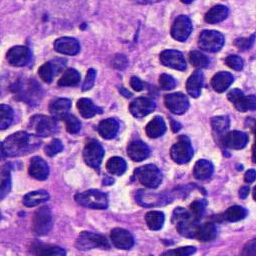

In [160]:
batch_tiles[1]

In [115]:
batch_df['tile_loc'].values

array([(144, 86), (362, 88), (161, 302), (365, 91), (380, 192), (87, 278),
       (96, 170), (342, 102), (257, 249), (196, 200), (470, 81),
       (275, 223), (591, 227), (235, 105), (449, 137), (124, 310),
       (448, 233), (211, 241), (452, 184), (244, 30), (546, 123),
       (134, 125), (315, 216), (282, 162), (146, 136), (180, 244),
       (415, 200), (611, 92), (390, 223), (420, 147), (315, 186),
       (94, 221)], dtype=object)

In [116]:
batch_size = 32
break_cnt = 0
for offset in range(0, len(patch_df), batch_size):
    batch_df = patch_df[offset:offset+batch_size]
    
    break_cnt += 1
    if break_cnt == 10:
        break

In [117]:
batch_size = 32
batch_df = patch_df[0:batch_size]

In [134]:
batch_df

,is_tissue,slide_path,is_tumor,tile_loc
32517,True,../data/train/16-S-042893_A1.mrxs,False,"(144, 86)"
87774,True,../data/train/16-S-042893_A1.mrxs,False,"(362, 88)"
37093,True,../data/train/16-S-042893_A1.mrxs,False,"(161, 302)"
88353,True,../data/train/16-S-042893_A1.mrxs,False,"(365, 91)"
91148,True,../data/train/16-S-042893_A1.mrxs,True,"(380, 192)"
19331,True,../data/train/16-S-042893_A1.mrxs,False,"(87, 278)"
21365,True,../data/train/16-S-042893_A1.mrxs,False,"(96, 170)"
83972,True,../data/train/16-S-042893_A1.mrxs,False,"(342, 102)"
63221,True,../data/train/16-S-042893_A1.mrxs,False,"(257, 249)"
46644,True,../data/train/16-S-042893_A1.mrxs,True,"(196, 200)"


In [146]:
a = tiles.get_tile(tiles.level_count-1, (221+30, 94+152))

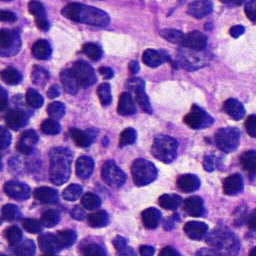

In [147]:
a

In [145]:
slide_lv4.size

(332, 625)